## Models

In [2]:
import requests
import time
from sklearn.feature_extraction import text
import re

import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words
import seaborn as sns


np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.

In [3]:
df = pd.read_csv('../data/CombinedSubReddits.csv')

In [4]:
df.columns

Index(['approved_at_utc', 'approved_by', 'archived', 'author',
       'author_cakeday', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'author_fullname',
       'banned_at_utc', 'banned_by', 'can_gild', 'can_mod_post', 'category',
       'clicked', 'content_categories', 'contest_mode', 'created',
       'created_utc', 'crosspost_parent', 'crosspost_parent_list',
       'distinguished', 'domain', 'downs', 'edited', 'gilded', 'hidden',
       'hide_score', 'id', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_self', 'is_video',
       'likes', 'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media',
       'media_embed', 'media_metadata', 'media_only', 

In [5]:
df_info = df[['sub', 'title', 'selftext', 'ups', 'num_comments']]

In [6]:
df_info.drop_duplicates(inplace=True)
df_info.reset_index(drop=True, inplace=True)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
df_info['selftext'].fillna('N/A', inplace=True)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [8]:
len(df_info)

1001

In [9]:
df_info.shape

(1001, 5)

In [10]:
df_info['text'] = df_info['title'] + df_info['selftext']

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
df_info.drop(columns = ['title', 'selftext'], inplace=True)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
X_text = []
X_text = df_info['text']

In [13]:
 def post_to_words(X_text):
    # Function to convert text from subreddit posts to a string of words

    # Clean punctuation, newlines
    X_text = re.sub("[^a-zA-Z]", " ", X_text)
    #
    X_text = re.sub(r"S?L+P+T+\W*", "", X_text)
    # Convert to all lowercase, split into individual words
    X_words = X_text.lower().split()

    stops = set(stopwords.words('english'))
    # Remove stop words
    meaningful_words = [w for w in X_words if not w in stops]

    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [14]:
# Get the number of posts based on the dataframe column size
num_posts = df_info.shape[0]

# Initialize an empty list to hold the clean posts
clean_X_text = []
num_posts

1001

In [15]:
df_info.text = df_info.text.apply(post_to_words)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [16]:
df_info.groupby('sub').count()

,ups,num_comments,text
sub,,,
0,500,500,500
1,501,501,501


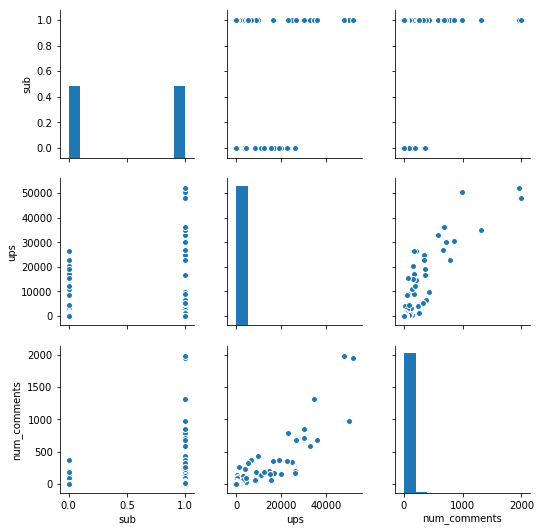

In [17]:
sns.pairplot(df_info);

## Train, test, split

In [18]:
X = df_info['text']
y = df_info['sub']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## CountVectorizer

In [19]:
custom_stopwords = list(stop_words.ENGLISH_STOP_WORDS)
custom_stopwords.extend({'LPT', 'SLPT', 'lpt', 'slpt', 'time', 'like', 'make', 'want', 'use'})
cvec = CountVectorizer(stop_words=custom_stopwords)

In [20]:
X_train_counts = cvec.fit_transform(X_train)
X_test_counts = cvec.transform(X_test)
print(X_train_counts.shape)
print(X_test_counts.shape)

(670, 4272)
(331, 4272)


TypeError: 'type' object is not subscriptable

In [21]:
target = df_info['sub'] 

In [22]:
top_term_dist = cvec.fit_transform(df_info['text'])
len(cvec.get_feature_names())
top_term_df = pd.DataFrame(top_term_dist.toarray(), columns=cvec.get_feature_names(), index=target)

In [23]:
top_term_df.to_csv('top_terms.csv', index=True)

In [24]:
word_total = top_term_df.sum()

In [25]:
word_total.to_csv('LPT_Word_Count.csv', index=True)

In [26]:
word_total.index

Index(['aaa', 'abandoned', 'abbreviating', 'abdominal', 'abilities', 'ability',
       'able', 'abort', 'aboutn', 'abroad',
       ...
       'youth', 'youtube', 'ytimg', 'zap', 'zapped', 'zeal', 'zen', 'zero',
       'zone', 'zones'],
      dtype='object', length=5354)

In [27]:
#top_term_df.insert(0,'target_', target)

In [28]:
top_term_df.groupby('sub').mean()

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'sub' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,aaa,abandoned,abbreviating,abdominal,abilities,ability,able,abort,aboutn,abroad,...,youth,youtube,ytimg,zap,zapped,zeal,zen,zero,zone,zones
sub,,,,,,,,,,,,,,,,,,,,,
0,0.002002,0.001001,0.001001,0.001001,0.002002,0.002002,0.018018,0.001001,0.001001,0.001001,...,0.001001,0.009009,0.001001,0.001001,0.001001,0.001001,0.001001,0.001001,0.001001,0.001001
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
top_term_df.groupby('sub').mean().T.sort_values(0, ascending=False).head(10)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'sub' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


sub,0,1
people,0.089089,0.0
know,0.087087,0.0
car,0.085085,0.0
amp,0.084084,0.0
way,0.084084,0.0
need,0.076076,0.0
work,0.065065,0.0
day,0.063063,0.0
say,0.062062,0.0
ask,0.062062,0.0


In [30]:
top_term_df.groupby('sub').mean().T.sort_values(1, ascending=False).head(10)

/Users/pauldcyr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'sub' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


sub,0,1
shittylifeprotipd,0.000000,0.5
post,0.013013,0.5
latern,0.000000,0.5
hours,0.013013,0.5
sup,0.000000,0.5
hot,0.023023,0.5
crosspost,0.000000,0.5
xpost,0.001001,0.5
steal,0.004004,0.5
page,0.009009,0.5


In [31]:
log_reg = LogisticRegression()
log_reg.fit(X_train_counts, y_train)
log_reg.score(X_test_counts, y_test)

0.7341389728096677

In [57]:
cvec2 = CountVectorizer(stop_words='english', binary=True)
X_train_counts2 = cvec2.fit_transform(X_train)
X_test_counts2 = cvec2.transform(X_test)
print(X_train_counts2.shape)
print(X_test_counts2.shape)

(670, 4278)
(331, 4278)


In [58]:
log_reg = LogisticRegression()
log_reg.fit(X_train_counts2, y_train)
log_reg.score(X_test_counts2, y_test)

0.7371601208459214

In [34]:
coefs = np.abs(log_reg.coef_)

In [35]:
np.argsort(coefs)[::-1]

array([[ 189, 2919, 3600, ..., 3095, 3946, 2151]])

## TFIDF

In [36]:
tfidf = TfidfVectorizer(stop_words='english')
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(670, 4278)
(331, 4278)


In [37]:
log_reg = LogisticRegression()
log_reg.fit(X_train_tf, y_train)
log_reg.score(X_test_tf, y_test)

0.7311178247734139

In [38]:
tfidf = TfidfVectorizer(stop_words='english', binary=True)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

print(X_train_tf.shape)
print(X_test_tf.shape)

(670, 4278)
(331, 4278)


In [39]:
log_reg = LogisticRegression()
log_reg.fit(X_train_tf, y_train)
log_reg.score(X_test_tf, y_test)

0.7492447129909365

In [40]:
tfidf_df = pd.DataFrame(tfidf.transform(X_train).todense(),
                   columns=tfidf.get_feature_names())

## Random Forest

In [41]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)

In [42]:
forest.fit(X_train_tf, y_train)
print('\n Random Forest')
print(forest.score(X_train_tf, y_train))
print(forest.score(X_test_tf, y_test))


 Random Forest
0.7686567164179104
0.6435045317220544


## Important Features

In [55]:
forest = RandomForestClassifier(max_depth = 10, n_estimators=5, random_state=42)
forest.fit(X_train, y_train)
f=forest.score(X_test, y_test)

pred=pd.DataFrame(forest.predict(X_test_counts))
pred.columns=['Predicted Subreddit']
importances = pd.Series(forest.feature_importances_, index=X_train.columns)

print(f)

importances=importances.sort_values(ascending=False)
importances=pd.DataFrame(importances,columns=['Importance'])
importances.index.name='Features'
importances['Rank']=importances.rank(ascending=False)
importances
pred=np.where(pred['Predicted Subreddit']==1,'LPT','SLPT')
pred.shape
X_test.shape
pred

ValueError: could not convert string to float: 'find iphones using safari search bar website tap search bar start typing keyword looking see page option shuffle keywords ease n'

## Pipeline

Using ups and number of comments to see if how they score on Pipeline of Standard Scaler and Logistic Regression

In [ ]:
# Train Test Split
X = df_info[['ups', 'num_comments']]
y = df_info['sub']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
ss = StandardScaler()
logreg = LogisticRegression()
pipe = Pipeline([('ss', ss),('logreg', logreg)])

In [ ]:
pipe.fit(X_train,  y_train)
pipe.score(X_test,  y_test)

In [ ]:
pipe.fit(X_train,  y_train)
pipe.score(X_test,  y_test)

In [ ]:
cross_val_score(pipe, X_test, y_test, cv=6).mean()

In [ ]:
# GridSearch to find best parameters:
params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [.3,.4,.5,.6,.7,.8,.9,1.0]
}
gs = GridSearchCV(pipe, param_grid=params, scoring='accuracy')
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

## Word and Character Count Graphs

In [ ]:
df_info['char_count'] = df.title.map(len)

In [ ]:
df_info['word_count'] = df.title.map(lambda x: len(x.split()))

In [ ]:
plt.figure(figsize=(20,10))
plt.hist([df_info[df_info['sub']==0]['char_count'], df_info[df_info['sub']==1]['char_count']],
         bins=20, color=['mediumseagreen', 'skyblue'], ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.legend(['Life Pro Tips', 'Shitty Life Pro Tips'])

In [ ]:
plt.figure(figsize=(20,10))
plt.hist([df_info[df_info['sub']==0]['word_count'], df_info[df_info['sub']==1]['word_count']],
         bins=20, color=['mediumseagreen', 'skyblue'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Life Pro Tips', 'Shitty Life Pro Tips'])

In [ ]:
sns.regplot(x=df_info['ups'], y=df_info['num_comments'], 
            line_kws={"color":"r","alpha":0.7,"lw":5})

## Executive Summary

This project provides analysis of the differences between two forums on the website Reddit. The two sub-reddits analyzed were 'Life Pro Tips' and 'Shitty Life Pro Tips'. Webscraping was used to acquirer the posts from each sub-reddit. The analysis's intent was to determine if you can use the words in the titles of each sub-reddit post to predict which sub-reddit that post came from. The methods of analysis used were Natural Language Processing to find insight on the most commonly used words in each sub-reddit. The analysis shows that both sub-reddits do use many words in common which made determining which sub-reddit posts came from, relatively hard. The best model did predict around 80% of the posts accurately.

To improve the model, collecting more posts to analysis and using ngram to find two or more word combinations that are will help the model be more predictive. Also detecting sarcasm would be very powerful since 'Life Pro Tips' are meant to be serious and 'Shitty Life Pro Tips' are meant to be facetious or sarcastic.